Enter the filename for the OLD Kalicube graph (e.g., link_graph_edges.csv): link_graph_edges.csv
Enter the filename for the NEW Kalicube graph (e.g., updated_link_graph_edges.csv): updated_link_graph_edges.csv
✅ Loaded OLD Kalicube graph from: link_graph_edges.csv
✅ Loaded NEW Kalicube graph from: updated_link_graph_edges.csv
⚙️ Simulating WWW Graph...
✅ WWW Graph Simulation Complete.
⚙️ Computing PageRank for OLD Kalicube Graph...
✅ Saved: kalicube_pagerank_before.csv
⚙️ Computing PageRank for NEW Kalicube Graph...
✅ Saved: kalicube_pagerank_after.csv
⚙️ Comparing PageRank results and generating plots...
✅ Saved: kalicube_pagerank_comparison.csv


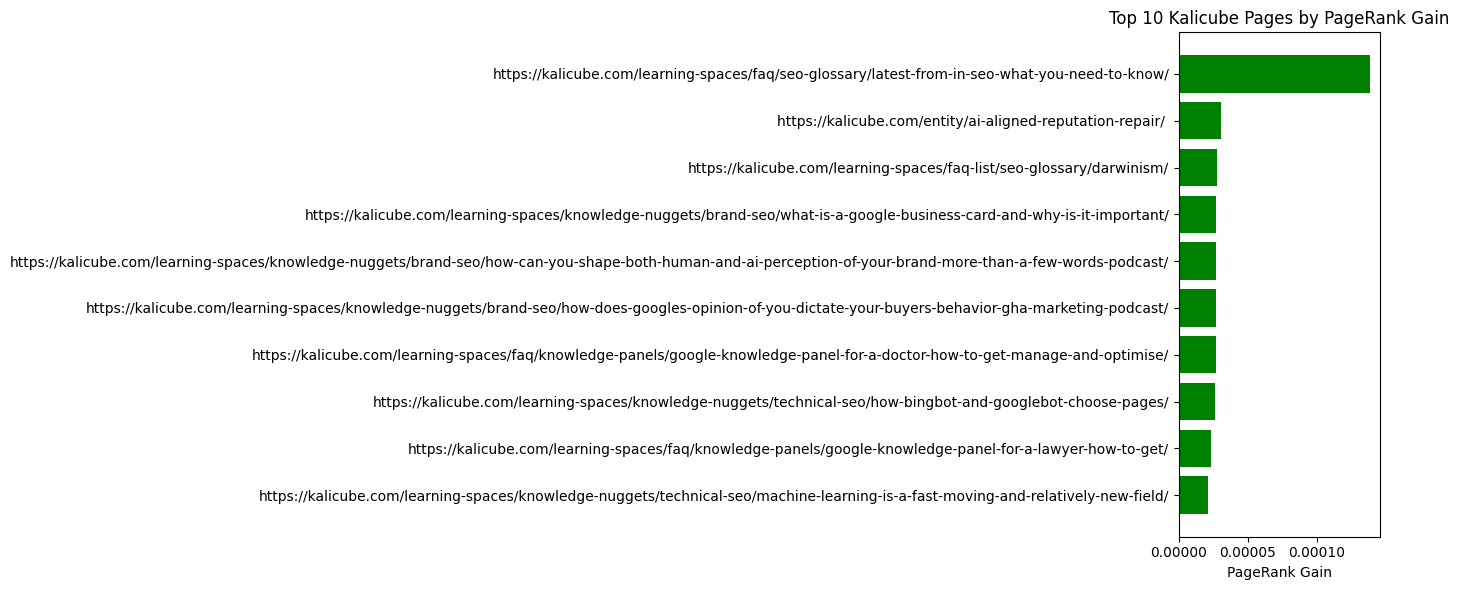

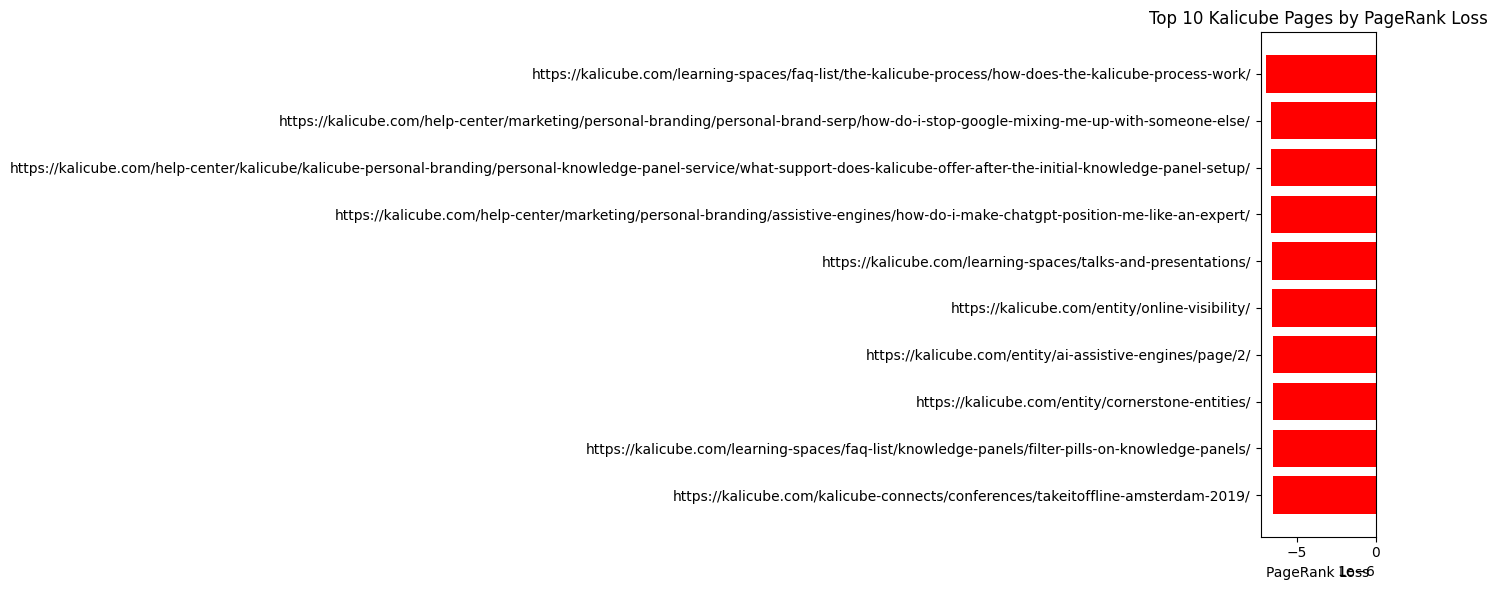

✅ Saved: kalicube_folder_summary.csv

📊 Overall PageRank Summary:
  Total Before: 0.173172
  Total After:  0.173804
  Change:       0.000632 (0.37%)
✅ Overall Effect: POSITIVE


In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import networkx as nx
import numpy as np
import random
import re
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

# --- User Input for Graph Files ---
old_graph_filename = input(
    "Enter the filename for the OLD Kalicube graph (e.g., link_graph_edges.csv): "
)
new_graph_filename = input(
    "Enter the filename for the NEW Kalicube graph (e.g., updated_link_graph_edges.csv): "
)

# -----------------------------
# Step 1: Load Kalicube Graphs
# -----------------------------
try:
    old_link_df = pd.read_csv(old_graph_filename)
    kalicube_graph_old = nx.from_pandas_edgelist(
        old_link_df, source="FROM", target="TO", create_using=nx.DiGraph()
    )
    print(f"✅ Loaded OLD Kalicube graph from: {old_graph_filename}")
except FileNotFoundError:
    print(
        f"❌ Error: {old_graph_filename} not found. Please ensure the file is in the same directory as the script."
    )
    exit()

try:
    new_link_df = pd.read_csv(new_graph_filename)
    kalicube_graph_new = nx.from_pandas_edgelist(
        new_link_df, source="FROM", target="TO", create_using=nx.DiGraph()
    )
    print(f"✅ Loaded NEW Kalicube graph from: {new_graph_filename}")
except FileNotFoundError:
    print(
        f"❌ Error: {new_graph_filename} not found. Please ensure the file is in the same directory as the script."
    )
    exit()


# -----------------------------
# Step 2: Simulate WWW Graph
# -----------------------------
total_nodes_www = 10000
edges_per_new_node = 3
www_graph = nx.DiGraph()

# Seed network
for i in range(edges_per_new_node):
    www_graph.add_node(i)
for i in range(edges_per_new_node):
    for j in range(i + 1, edges_per_new_node):
        www_graph.add_edge(i, j)

# Initialize a dictionary to keep track of in-degrees for efficient updates
in_degrees = {n: www_graph.in_degree(n) for n in www_graph.nodes()}

# Add new nodes with preferential attachment
print("⚙️ Simulating WWW Graph...")
for i in range(edges_per_new_node, total_nodes_www):
    www_graph.add_node(i)
    in_degrees[i] = 0  # New node has an in-degree of 0

    # Use the dictionary to find nodes with non-zero degrees and calculate total degree
    nonzero_nodes = [n for n, d in in_degrees.items() if d > 0]
    total_degree = sum(in_degrees.values())

    if total_degree == 0 or len(nonzero_nodes) < edges_per_new_node:
        targets = random.sample(list(www_graph.nodes()), edges_per_new_node)
    else:
        # Calculate probabilities from the in_degrees dictionary
        degrees_array = np.array([in_degrees[n] for n in nonzero_nodes])
        probabilities = degrees_array / degrees_array.sum()
        targets = np.random.choice(
            nonzero_nodes, size=edges_per_new_node, replace=False, p=probabilities
        )

    for t in targets:
        www_graph.add_edge(i, t)
        in_degrees[t] += 1  # Increment the degree of the target node
print("✅ WWW Graph Simulation Complete.")

# ----------------------------------------------------
# Step 3 & 4: Merge Graphs and Compute PageRank (OLD)
# ----------------------------------------------------
print("⚙️ Computing PageRank for OLD Kalicube Graph...")
merged_graph_old = nx.compose(www_graph, kalicube_graph_old)

# Add interconnection edges between WWW and OLD Kalicube graph
www_nodes_sample_old = random.sample(
    [n for n in www_graph.nodes if isinstance(n, int)], 10
)
kalicube_nodes_sample_old = random.sample(list(kalicube_graph_old.nodes()), 10)
for www_node, kalicube_node in zip(www_nodes_sample_old, kalicube_nodes_sample_old):
    merged_graph_old.add_edge(www_node, kalicube_node)


pagerank_old = nx.pagerank(
    merged_graph_old, alpha=0.85
)  # The networkx.pagerank function handles dangling nodes by default, distributing their PageRank uniformly among all nodes.

# Explicitly delete the large graph object after PageRank is computed to free memory
del merged_graph_old

# Filter for Kalicube nodes only
kalicube_pagerank_old = {
    node: score
    for node, score in pagerank_old.items()
    if node in kalicube_graph_old.nodes()
}
# Delete the full pagerank dict to save memory, as we only need the filtered one
del pagerank_old

pagerank_old_df = pd.DataFrame(
    list(kalicube_pagerank_old.items()), columns=["URL", "PageRank_Before"]
)
pagerank_old_df.to_csv("kalicube_pagerank_before.csv", index=False)
print("✅ Saved: kalicube_pagerank_before.csv")


# ----------------------------------------------------
# Step 3 & 4: Merge Graphs and Compute PageRank (NEW)
# ----------------------------------------------------
print("⚙️ Computing PageRank for NEW Kalicube Graph...")
merged_graph_new = nx.compose(www_graph, kalicube_graph_new)

# Explicitly delete www_graph after merging to free up memory (only need it for initial compose)
# However, for both old and new graphs to interact with the SAME www_graph, we should not delete it until both are processed.
# So, www_graph is implicitly deleted when the script finishes, or if we were to wrap this in a function.

# Add interconnection edges between WWW and NEW Kalicube graph
www_nodes_sample_new = random.sample(
    [n for n in www_graph.nodes if isinstance(n, int)], 10
)
kalicube_nodes_sample_new = random.sample(list(kalicube_graph_new.nodes()), 10)
for www_node, kalicube_node in zip(www_nodes_sample_new, kalicube_nodes_sample_new):
    merged_graph_new.add_edge(www_node, kalicube_node)


pagerank_new = nx.pagerank(
    merged_graph_new, alpha=0.85
)  # The networkx.pagerank function handles dangling nodes by default, distributing their PageRank uniformly among all nodes.

# Explicitly delete the large graph object after PageRank is computed
del merged_graph_new

# Filter for Kalicube nodes only
kalicube_pagerank_new = {
    node: score
    for node, score in pagerank_new.items()
    if node in kalicube_graph_new.nodes()
}
# Delete the full pagerank dict to save memory
del pagerank_new

pagerank_new_df = pd.DataFrame(
    list(kalicube_pagerank_new.items()), columns=["URL", "PageRank_After"]
)
pagerank_new_df.to_csv("kalicube_pagerank_after.csv", index=False)
print("✅ Saved: kalicube_pagerank_after.csv")


# -----------------------------
# Comparing the changes
# -----------------------------
print("⚙️ Comparing PageRank results and generating plots...")

# Step 1: Load PageRank Data (already have them in memory)
before_df = pagerank_old_df
after_df = pagerank_new_df

# Step 2: Compare Before vs. After
comparison_df = before_df.merge(after_df, on="URL", how="outer").fillna(0)
comparison_df["Delta"] = (
    comparison_df["PageRank_After"] - comparison_df["PageRank_Before"]
)
comparison_df["Delta_%"] = (
    comparison_df["Delta"] / comparison_df["PageRank_Before"].replace(0, 1e-10)
) * 100

# Save comparison
comparison_df.to_csv("kalicube_pagerank_comparison.csv", index=False)
print("✅ Saved: kalicube_pagerank_comparison.csv")

# -----------------------------
# Step 3: Visualize Top Gains
# -----------------------------
top_gains = comparison_df.sort_values(by="Delta", ascending=False).head(10)
plt.figure(figsize=(14, 6))
plt.barh(top_gains["URL"], top_gains["Delta"], color="green")
plt.xlabel("PageRank Gain")
plt.title("Top 10 Kalicube Pages by PageRank Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# -----------------------------
# Step 4: Visualize Top Losses
# -----------------------------
top_losses = comparison_df.sort_values(by="Delta", ascending=True).head(10)
plt.figure(figsize=(14, 6))
plt.barh(top_losses["URL"], top_losses["Delta"], color="red")
plt.xlabel("PageRank Loss")
plt.title("Top 10 Kalicube Pages by PageRank Loss")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# -----------------------------
# Step 5: Grouped Summary by Folder
# -----------------------------
def extract_top_folder(url):
    """
    Extracts the top-level folder from a Kalicube URL.
    Examples:
    - "https://www.kalicube.com/folder/page" -> "folder"
    - "https://www.kalicube.com/about" -> "about"
    - "https://www.kalicube.com" -> "root"
    - "https://www.kalicube.com/" -> "root"
    - "www.kalicube.com/folder/page" -> "folder"
    """
    # Use regex to find the part of the URL after the domain and before the next slash.
    # This is more robust than splitting by 'kalicube.com/'
    match = re.search(r"kalicube\.com/?([^/]+)", url, re.IGNORECASE)
    if match:
        return match.group(1)
    else:
        return (
            "root"  # Return 'root' for URLs like 'kalicube.com' or 'www.kalicube.com'
        )


comparison_df["TopFolder"] = comparison_df["URL"].apply(extract_top_folder)

group_summary = (
    comparison_df.groupby("TopFolder")
    .agg(
        PageRank_Before=("PageRank_Before", "sum"),
        PageRank_After=("PageRank_After", "sum"),
        Delta=("Delta", "sum"),
        Count=("URL", "count"),
    )
    .reset_index()
)

group_summary["Delta_%"] = (
    group_summary["Delta"] / group_summary["PageRank_Before"].replace(0, 1e-10)
) * 100

group_summary = group_summary.sort_values(by="Delta", ascending=False)
group_summary.to_csv("kalicube_folder_summary.csv", index=False)
print("✅ Saved: kalicube_folder_summary.csv")

# -----------------------------
# Step 6: Overall Effect
# -----------------------------
total_before = comparison_df["PageRank_Before"].sum()
total_after = comparison_df["PageRank_After"].sum()
total_delta = total_after - total_before
delta_pct = (total_delta / total_before) * 100 if total_before > 0 else float("inf")

print("\n📊 Overall PageRank Summary:")
print(f"  Total Before: {total_before:.6f}")
print(f"  Total After:  {total_after:.6f}")
print(f"  Change:       {total_delta:.6f} ({delta_pct:.2f}%)")

if total_delta > 0:
    print("✅ Overall Effect: POSITIVE")
elif total_delta < 0:
    print("⚠️ Overall Effect: NEGATIVE")
else:
    print("➖ Overall Effect: NEUTRAL")